In [ ]:
# Import libraries
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import AUC, Precision, Recall
import pickle
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Charging the X and y data
X = pd.read_csv('../save_model/X_train.csv')
y = pd.read_csv('../save_model/y_train.csv')

In [ ]:
# Divide data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [14]:
input_layer = Input(shape=(X_train.shape[1],))

x = Dense(256, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)

# 4 clases -> 4 neuronas y softmax
output = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # para etiquetas como 0,1,2,3
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,300 (184.77 KB)

 Trainable params: 46,404 (181.27 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
#class_weights = class_weight.compute_class_weight(
#    class_weight='balanced',
#    classes=np.unique(y_train.flatten()),
#    y=y_train.flatten()
#)
#
#class_weights = {i: w for i, w in enumerate(class_weights)}

In [ ]:
#from imblearn.over_sampling import SMOTE
#
#sm = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
## view zeros and ones in y_train_resampled
#print("Train: ", y_train_resampled.sum(), "Val: ", y_val.sum(), "Test: ", y_test.sum())
#print("Train: ", y_train_resampled.shape[0], "Val: ", y_val.shape[0], "Test: ", y_test.shape[0])
#print("Train: ", y_train_resampled.shape[0] - y_train_resampled.sum(), "Val: ", y_val.shape[0] - y_val.sum(), "Test: ", y_test.shape[0] - y_test.sum())

Train:  5233 Val:  1537 Test:  1638
Train:  10466 Val:  1720 Test:  1723
Train:  5233 Val:  183 Test:  85


In [19]:
# Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    #validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=32,
    #callbacks=[early_stopping],
    #class_weight=class_weights
)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4441 - loss: 1.2387 
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4572 - loss: 1.1908 
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4705 - loss: 1.1752 
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4761 - loss: 1.1779 
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5017 - loss: 1.1203 
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4967 - loss: 1.1758 
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5237 - loss: 1.0974 
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5067 - loss: 1.1324 
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4588 - loss: 1.2049 
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4753 - loss: 1.1595 
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4895 - loss: 1.1317 
Epoch 12/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 

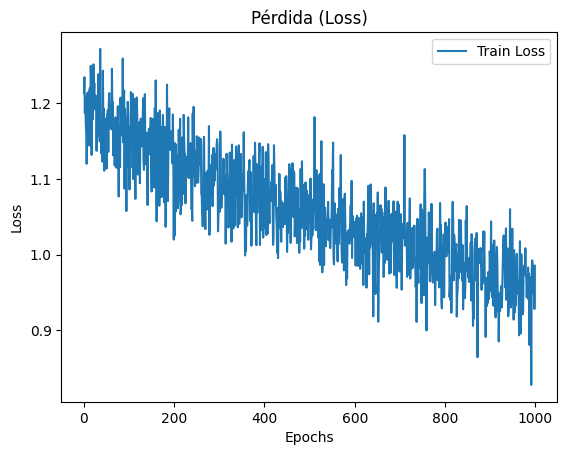

In [20]:
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

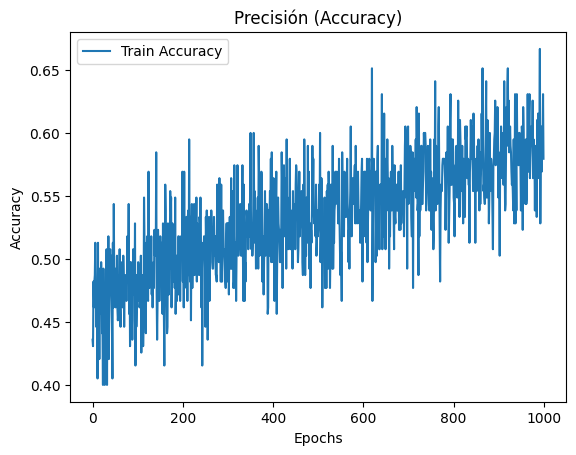

In [21]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
#plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Precisión (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


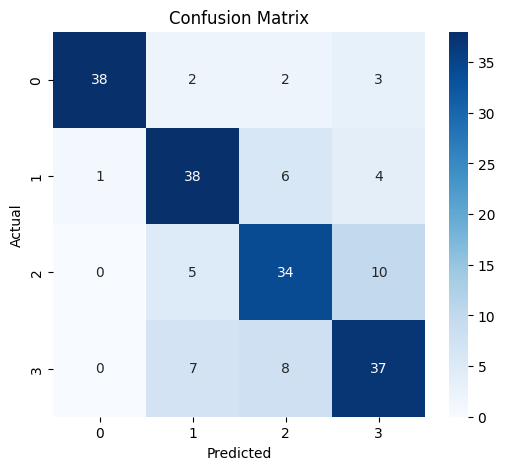

In [24]:
# 4 engagement
y_pred_probs = model.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_train, y_pred)

# Opcional: Mostrar como heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
print(classification_report(y_train, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.974     0.844     0.905        45
           1      0.731     0.776     0.752        49
           2      0.680     0.694     0.687        49
           3      0.685     0.712     0.698        52

    accuracy                          0.754       195
   macro avg      0.768     0.756     0.761       195
weighted avg      0.762     0.754     0.757       195

